# Continuous Control - Deep Deterministic Policy Gradient (DDPG)

This notebook will implement the DDPG algorithm defined in Lillicrap, et al, ["Continous Control With Deep Reinforcement Learning (2016)"](https://arxiv.org/pdf/1509.02971.pdf), which aims to train an reinforcement learning agent in environments with continous values for both state and action spaces.

Up to this point, we have seen environments with discrete state/action spaces, or with continuous state spaces and discrete action spaces. Being able to train an agent on such an environment holds great potential for real-world applications, such as robotics. 

This approach is heavily inspired by the DQN algorithm presented by Mnih, et al., in ["Human Level Control Through Deep Reinforcement Learning (2015)"](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf). If you are unfamiliar with this algorithm, please refer to the detailed explanation/implementation elsewhere in my github. 

One restriction of the DQN algorithm is that is it must operate on discrete action spaces. In order to apply the algorithm to environments with continous action spaces, Lillicrap, et al. introduced DPG and an actor-critic architecture. 

The following cells explain this architecture in detail.


### Import Necessary Packages

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
from collections import deque, namedtuple
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from utils import OUNoise, ReplayBuffer


%matplotlib inline

load environment for a single agent and obtain default brain.
if you are unfamiliar with Unity Machine Learning Agents, please refer to the documentation at
https://unity3d.com/machine-learning.

In [2]:
env = UnityEnvironment(file_name="..\p2_continuous_control\Reacher_Windows\Reacher.exe", no_graphics=False)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

In [3]:
# environment information
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
States have length: 33


If GPU available, take advantage of acceleration

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###  The Actor

DDPG deviates from the "normal" actor-critic architecture in several ones. One of those ways is the implementation of the actor. In DDPG, the actor implements a deterministic policy, in that the actor strives to learn the action that will produce the largest expected return. 

Usually, an actor implements a stochasitc policy by returning a probability distribution over the action space.

The paper trained the agent on both pixel data and lower-dimensional data, similar to the state vector in this environment. The authors used 400 and 300 units in the hidden layers for both actor and critic.

Lastly, in order to limit the output of the action space, the tanh function is used. This function returns values between -1 and 1. This is a key feature of operating within the continous action space. Rather than produce a single integer value corresponding to a discrete action - i.e., 1 for "turn left" - the actor produces values within a range. In this case, that range corresponds to the amount of torque applied to each joint of the arm.

Note: The paper uses 400/300 units for hidden layers. In testing, this was unncessary for this environment.

In [5]:
class Actor(nn.Module):
    """ 
    
    Actor Model will approximate the policy function, which maps states to actions. 
    
    """

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """
        Initialize parameters and build model.
        
        Params
        ======
            
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        # randomly initilze weights via normal distribution
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """
        
        Build an actor (policy) network that maps states -> actions.
        
        """
        
        # rectified linear units are used as activation functions
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        # the output of the network will be values between -1 and 1. This corresponds to the action space range
        # of our unity environment.
        return torch.tanh(self.fc3(x))

### The Critic

Again, the DDPG algorithm deviates from normal actor-critic method in the implementation of the critic. 

Usually, the critic functions as a baseline for the actor, which reduces the variance that is inherent in the actors pure policy pursuit. 

This variance is still reduced, however, but through different means. Much like the original DQN algorithm, the actor approximates the value function, Q(s,a), by estimating TD rewards. This approach introduces a bias to the system, but also is used to reduce the variance of the actor, since neural network function approximation using estimated returns inherently has low variance and higher bias. 

Note: The paper uses 400/300 units for hidden layers. In testing, this was unncessary for this environment.

In [6]:
class Critic(nn.Module):
    """
    
    Critic Model will approximate the value function, which maps a (state, action) pair to an expected reward.
    
    """

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=64):
        """
        
        Initialize parameters and build model.
        
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        
        # The paper concatenates the action values to the output of the first layer for layer 2.
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)

        
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        
        # according to the paper, actions are not included until the second hidden layer.
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### The Agent

The authors state that network performance was very unstable through many environments when directly implementing Q learning. This behavior was also seen by Mnih, et al, who used Fixed Q-Targets to stabilize this divergent behavior. The authors also implemented the same tactic here by using a local and target network for both the actor and critic. 

Unlike DQN, the authors reduced the rate at which the target networks "learned". In DQN, a 1:1 copying of network paramters is performed as some arbitrary interval. In this approach, the authors implement a soft-update. Gradually moving local network parameters toward target parameters, which greatly stabilized the learning rate.

As with DQN, the authors chose to implement a Replay Buffer. This Replay Buffer is identical to that seen in DQN. Please refer to that implementation (located in this github) for a detailed explanation. 

Lastly, in order to promote exploration within the action space, the authors introduced an Ornstein_Uhlenbeck process which generates temporally correlated exploration for exploration efficiency in physical control problems with inertia. Since this algorithm has existed for quite some time, no explanation will be given. 

This noise is added to the output of the actor.

Note: the agent implementation is very similar to the DQN algorithm. The major change occurs in the learn() function. 

In [7]:
class Agent():        
    
    # most of these paramters were taken from the paper. 
    # However, some fine tuning was needed for this Unity environment.
    
    def __init__(self, device, state_size, action_size, n_agents, 
                 random_seed=np.random.randint(int(1e5)),
                 buffer_size=int(1e5), 
                 batch_size=128, 
                 gamma=0.99, 
                 tau=1e-3, 
                 lr_actor=1e-4, 
                 lr_critic=1e-4):        

        # torch gpu or cpu device
        self.device = device
        
        # environment info
        self.state_size = state_size
        self.n_agents = n_agents
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # hyperparameters
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.gamma = gamma
        self.tau = tau
        

        # actor network 
        # target network stabilizes divergence while training.
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lr_actor)

        # critic network 
        # target network stabilizes divergence while trainig.
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=lr_critic)

        # noise process added to actor output. encourages exploration of the action space during training
        self.noise = OUNoise((n_agents, action_size), random_seed)

        # replay memory, where experience tuples are sampled uniformly
        self.memory = ReplayBuffer(device, action_size, buffer_size, batch_size, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """
        Save experience in replay memory, and use random sample from buffer to learn.
        """
        
        # store experience tuples. 
        # in cases where multiple agents are running, tuples are indexed per agent
        for i in range(self.n_agents):
            self.memory.add(state[i,:], action[i,:], reward[i], next_state[i,:], done[i])

        
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

    def act(self, state, add_noise=True):
        """
        Returns actions for given state as per current policy.
        """
        
        state = torch.from_numpy(state).float().to(self.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()        
        if add_noise:
            action += self.noise.sample()
            
        # clip, in cases where noise added sets values greater than +/- 1
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences):
        """
        
        Update policy and value parameters using given batch of experience tuples.
        
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        
        Please read this notebook's readme for a more detailed explanation.
        
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # Clip gradients to avoid large deviations; stabilizes learning.
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target)

    def soft_update(self, local_model, target_model):
        """
        Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
           

### Train the Agent

This training cell is identical to the other training cells seen elsewhere in my github. For a detailed explanation, see other reinforcement learning notebooks.

Episode: 	253 	Score: 	37.72 	Average Score: 	30.00
Environment solved in 253 episodes!	Average Score: 30.00


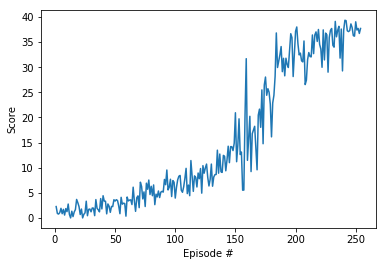

In [8]:
def ddpg_train():
    scores = []
    scores_window = deque(maxlen=100)
    n_episodes = 1000

    for episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]            # reset the environment
        states = env_info.vector_observations
        agent.reset()                                                # reset the agent noise
        score = np.zeros(n_agents)
        
        while True:
            actions = agent.act(states)
        
            env_info = env.step(
                 actions)[brain_name]               # send the action to the environment                            
            next_states = env_info.vector_observations               # get the next state        
            rewards = env_info.rewards                               # get the reward        
            dones = env_info.local_done                              # see if episode has finished        

            agent.step(states, actions, rewards, next_states, dones)

            score += rewards                                         # update the score
        
            states = next_states                                     # roll over the state to next time step        
                                                        
            if np.any(dones):                                          # exit loop if episode finished        
                break                                        

        scores.append(np.mean(score))
        scores_window.append(np.mean(score))

        print('\rEpisode: \t{} \tScore: \t{:.2f} \tAverage Score: \t{:.2f}'.format(episode, np.mean(score), np.mean(scores_window)), end="")  
        
        if np.mean(scores_window) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')      
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break    

    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()    

# create agent
agent = Agent(device, state_size, action_size, n_agents)

# train the agent
ddpg_train()

### Watch the Smart Agent Track A Target!

In [9]:
# test the trained agent
agent_test = Agent(device, state_size, action_size, n_agents)
agent_test.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent_test.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

for episode in range(3):
    env_info = env.reset(train_mode=False)[brain_name]        
    states = env_info.vector_observations       
    score = np.zeros(n_agents)               
    
    while True:
        actions = agent_test.act(states, add_noise=False)                    
        env_info = env.step(actions)[brain_name]        
        next_states = env_info.vector_observations     
        rewards = env_info.rewards       
        dones = env_info.local_done
        score += rewards
        states = next_states

        if np.any(dones):                              
            break

    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode, np.mean(score)))      

Episode: 	0 	Score: 	39.57
Episode: 	1 	Score: 	38.55
Episode: 	2 	Score: 	39.55


In [10]:
env.close()

### Future Work

Enhancements that can be applied to this approach is Prioritized Experience Replay. Being able to identify and use experience tuples that have the greatest potential for learning has been shown to rapidly advance learning of an agent, as well as produce a higher quality policy. 